## Importing the nn library and applying to a tensor.

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch import optim
import numpy as np

In [2]:
linear_model = nn.Linear(1, 1)
linear_model

Linear(in_features=1, out_features=1, bias=True)

In [3]:
y = Tensor([1,2,3]).unsqueeze(1)
print(y.shape)
linear_model(y)

torch.Size([3, 1])


tensor([[-0.7021],
        [-0.9872],
        [-1.2724]], grad_fn=<AddmmBackward>)

# Building a training loop for a linear model

## The motivation for this is to be aware that torch isn't just neural nets; it's general purpose backprop and autograd.

## First we'll generate some data                                         

In [4]:
n_samples = 50
n_val = int(0.2 * n_samples)
x = np.random.rand(n_samples)
y = 3*x + 4 + (np.random.rand(n_samples) - 0.5) # y ~ 3x + 4 with uniform noise

shuffledIndices = torch.randperm(n_samples)
trainIndices = shuffledIndices[:-n_val]
valIndices = shuffledIndices[-n_val:]

x_train, y_train = x[trainIndices], y[trainIndices]
x_val, y_val = x[valIndices], y[valIndices]
data = [x_train, x_val, y_train, y_val] # collecting in a single var to unpack later.
data = [torch.from_numpy(d).float().unsqueeze(1) for d in data] # put data into clean form for Torch

## Next our training loop definiton

In [5]:
def training_loop(n_epochs, optimizer, model, loss, x_train, x_val, y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        pred_train = model(x_train)
        loss_train = loss(pred_train, y_train)
        
        pred_val   = model(x_val)
        loss_val   = loss(pred_val, y_val)
        
        optimizer.zero_grad() # zero out accumulated gradient
        loss_train.backward() # backprop step
        optimizer.step() # gradient descent
        
        if epoch == 1 or epoch % 500 == 0:
            print(f" Epoch: {epoch}, Training/Validation Losses {loss_train}/{loss_val}")

## Model run

In [6]:
linear_model = nn.Linear(1, 1) # should be sufficient for our linearly generated data
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2) # SGD optimizer

training_loop(3000,
              optimizer,
              linear_model,
              nn.MSELoss(),
              *data
             )

print(linear_model.weight)
print(linear_model.bias)

 Epoch: 1, Training/Validation Losses 47.199974060058594/46.10014724731445
 Epoch: 500, Training/Validation Losses 0.08394346386194229/0.08150941133499146
 Epoch: 1000, Training/Validation Losses 0.06899469345808029/0.0903770700097084
 Epoch: 1500, Training/Validation Losses 0.06516867876052856/0.09828539192676544
 Epoch: 2000, Training/Validation Losses 0.06418942660093307/0.10316126048564911
 Epoch: 2500, Training/Validation Losses 0.06393881142139435/0.10585210472345352
 Epoch: 3000, Training/Validation Losses 0.06387465447187424/0.10727044194936752
Parameter containing:
tensor([[3.0965]], requires_grad=True)
Parameter containing:
tensor([3.8837], requires_grad=True)


## Now we'll exchange the linear model above for a non-linear model (NN)

In [7]:
from collections import OrderedDict

def make_seq_model(hidden_shape):
    return nn.Sequential(
            OrderedDict({
                "Hidden Layer": nn.Linear(1,hidden_shape),
                "Hyperbolic Activation": nn.Tanh(),
                "Output Layer": nn.Linear(hidden_shape,1)})
    )
seq_model = make_seq_model(13)
seq_model

Sequential(
  (Hidden Layer): Linear(in_features=1, out_features=13, bias=True)
  (Hyperbolic Activation): Tanh()
  (Output Layer): Linear(in_features=13, out_features=1, bias=True)
)

## Before plugging this into our training loop, let's inspect it more:

In [8]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

Hidden Layer.weight torch.Size([13, 1])
Hidden Layer.bias torch.Size([13])
Output Layer.weight torch.Size([1, 13])
Output Layer.bias torch.Size([1])


In [9]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    5000,
    optimizer,
    seq_model,
    nn.MSELoss(),
    *data)

print(f"Estimated Outputs {seq_model(torch.Tensor(x_val).unsqueeze(1))}")
print(f"Ground Truth {y_val}")

 Epoch: 1, Training/Validation Losses 41.954551696777344/41.83061981201172
 Epoch: 500, Training/Validation Losses 0.5207550525665283/0.3204735815525055
 Epoch: 1000, Training/Validation Losses 0.37821248173713684/0.2288205623626709
 Epoch: 1500, Training/Validation Losses 0.27226579189300537/0.16643770039081573
 Epoch: 2000, Training/Validation Losses 0.19562450051307678/0.1265135407447815
 Epoch: 2500, Training/Validation Losses 0.1433933824300766/0.1043158769607544
 Epoch: 3000, Training/Validation Losses 0.1101730614900589/0.0947602242231369
 Epoch: 3500, Training/Validation Losses 0.0903828889131546/0.0929775983095169
 Epoch: 4000, Training/Validation Losses 0.07922680675983429/0.09514031559228897
 Epoch: 4500, Training/Validation Losses 0.07319621741771698/0.09875273704528809
 Epoch: 5000, Training/Validation Losses 0.07002326101064682/0.1024555191397667
Estimated Outputs tensor([[4.6721],
        [4.9915],
        [6.0840],
        [4.5122],
        [5.5807],
        [4.0634],
 

## Let's visualize the neural network fit:

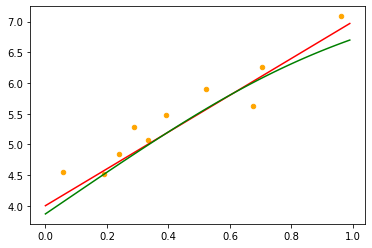

In [10]:
from matplotlib import pyplot as plt

x_range = torch.arange(0., 1., 0.01).unsqueeze(1)
plt.scatter(x_val, y_val, s=20, c="orange")
plt.plot(x_range.numpy(), 3*x_range.numpy() + 4, c="red")
plt.plot(x_range.numpy(), seq_model(x_range).detach().numpy(), c="green")

### As expected, the ANN appears to be overfitting the true signal. The most appropriate model would be an OLS linear regressor, but the above exploration helps paint what Torch is really capable of.